In [1]:
# load general tools
import sys
sys.path.append("../..")
from IPython.display import display
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.precision', 2)
pd.set_option('display.max_colwidth', 50)

In [12]:
# load magine specific tools
import magine.networks.ontology_network as nt
import magine.networks.visualization.notebooks.view as view
from magine.enrichment import load_enrichment_csv

from magine.plotting.heatmaps import heatmap_from_array, heatmap_by_category
from magine.plotting.venn_diagram_maker import create_venn2
from magine.plotting.wordcloud_tools import create_wordcloud

from magine.networks.utils import trim_sink_source_nodes, delete_disconnected_network
from magine.networks.visualization.igraph_tools import paint_network_overtime
from magine.networks.subgraphs import Subgraph
from magine.enrichment.enrichr import db_types

In [3]:
from exp_data import exp_data
network = nx.read_gpickle('Networks/cisplatin_network_w_attributes.p')
net_sub = Subgraph(network)

# Exploring enrichment output

Here we load in the results from enrichR

In [4]:
enrichment_array = load_enrichment_csv('Data/cisplatin_enrichment.csv.gz', index_col=0)
enrichment_array['significant'] = False
enrichment_array.loc[enrichment_array['adj_p_value']<=0.05, 'significant'] = True

In [15]:
all_data = enrichment_array.filter_multi(
    p_value=0.05, # only sig pvalues
    combined_score=0.0, # score threshold of positive values 
#     rank=50, # select top 100 from each time point
#     db=db_types['pathways'],
    db=[ 'Reactome_2016'],
    category=['proteomics_up', 'proteomics_down', 'proteomics_both']
)
print(all_data.shape)
print(db_types['pathways'],)
all_data['term_name'] = all_data['term_name'].str.split('_').str.get(0)
# all_data = all_data.loc[~all_data['term_name'].isin(not_useful)]
print(all_data.shape)

(1739, 11)
(['KEGG_2016', 'WikiPathways_2016', 'Reactome_2016', 'BioCarta_2016', 'NCI-Nature_2016', 'Panther_2016', 'BioPlex_2017'],)
(1739, 11)


In [16]:
all_data.remove_redundant(inplace=True, level='sample', threshold=.5)
all_data.remove_redundant(inplace=True, level='dataframe', threshold=.5)
print(all_data.shape)
all_data.filter_by_minimum_sig_columns(columns='sample_id', index=['term_name', 'category'], min_terms=3, inplace=True)
print(all_data.shape)

Number of rows went from 1739 to 876
Number of rows went from 876 to 538
(538, 11)
(352, 11)


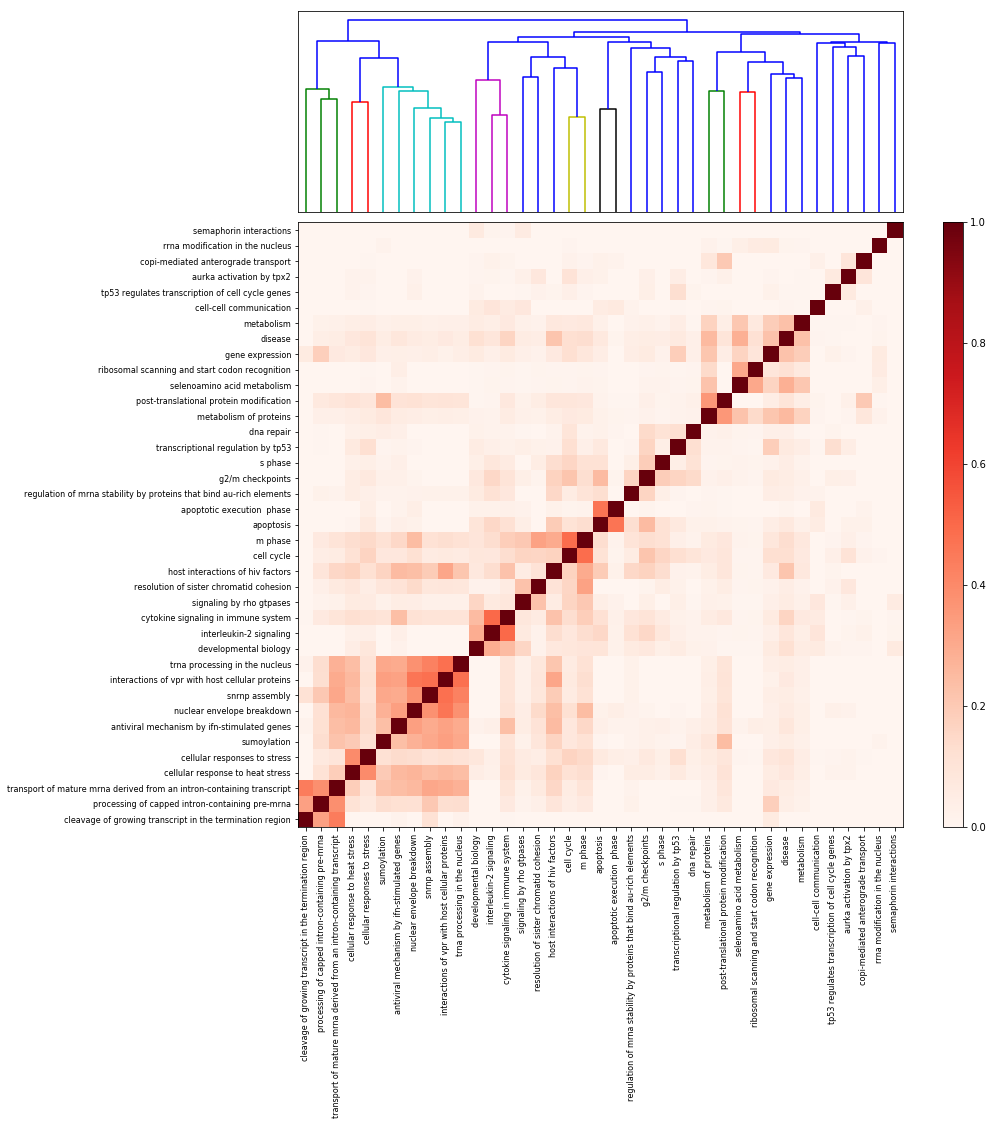

In [7]:
all_data.dist_matrix(level='sample', fig_size=(14,14));

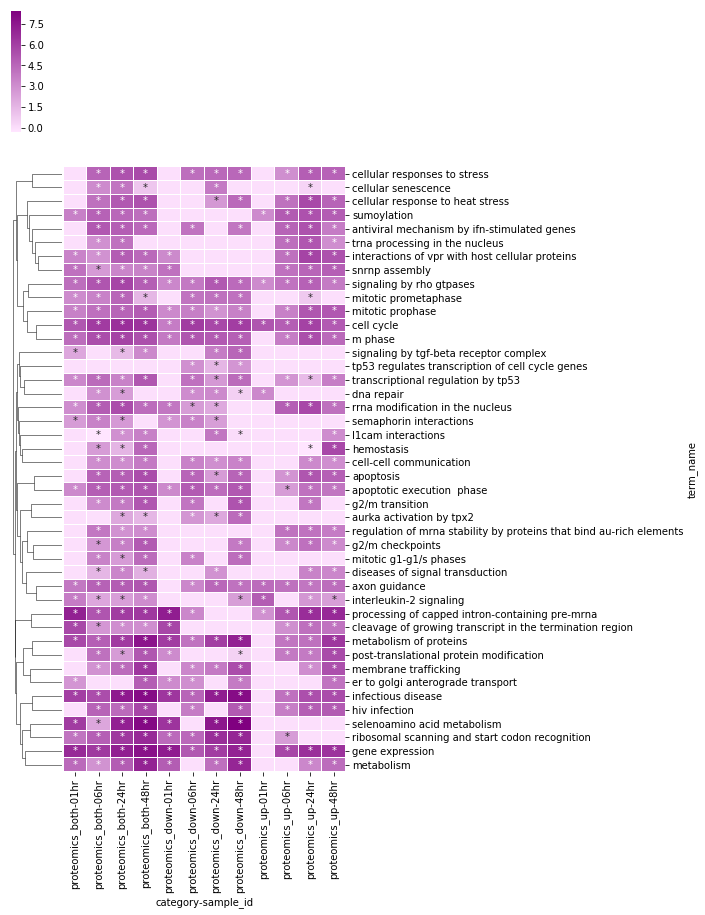

In [17]:
heatmap_from_array(all_data, convert_to_log=True, index='term_name',
                   columns=['category', 'sample_id'],
                   fig_size=(6,14), annotate_sig=True, linewidths=.01,
                   cluster_row=True, cluster_by_set=True);

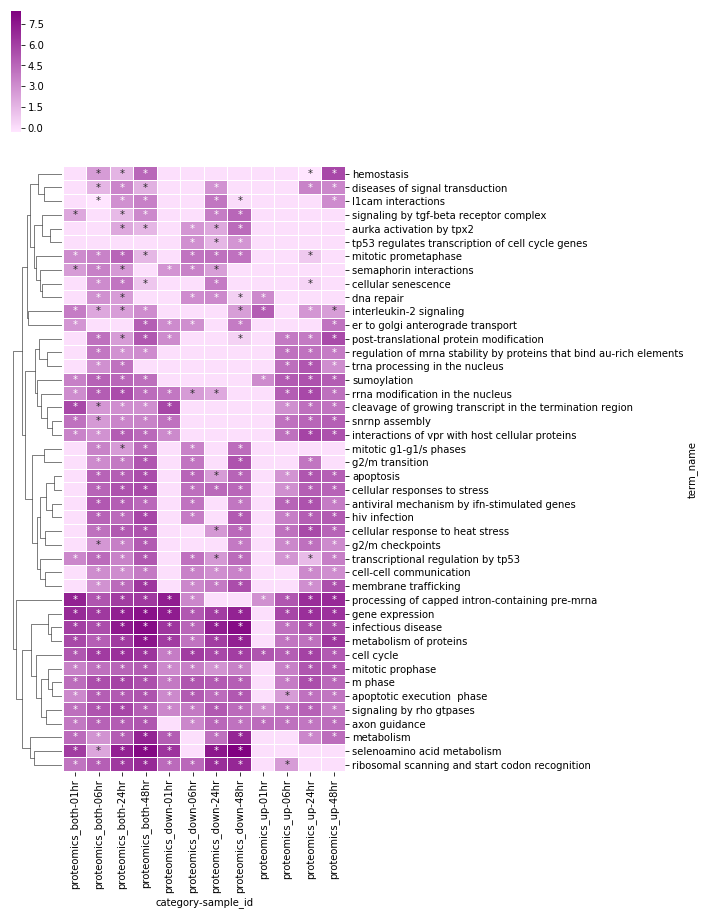

In [18]:
heatmap_from_array(all_data, convert_to_log=True, index='term_name',
                   columns=['category', 'sample_id'],
                   fig_size=(6,14), annotate_sig=True, linewidths=.01,
                   cluster_row=True, cluster_by_set=False);

In [ ]:
iris = sns.load_dataset("iris")
iris.head(10)

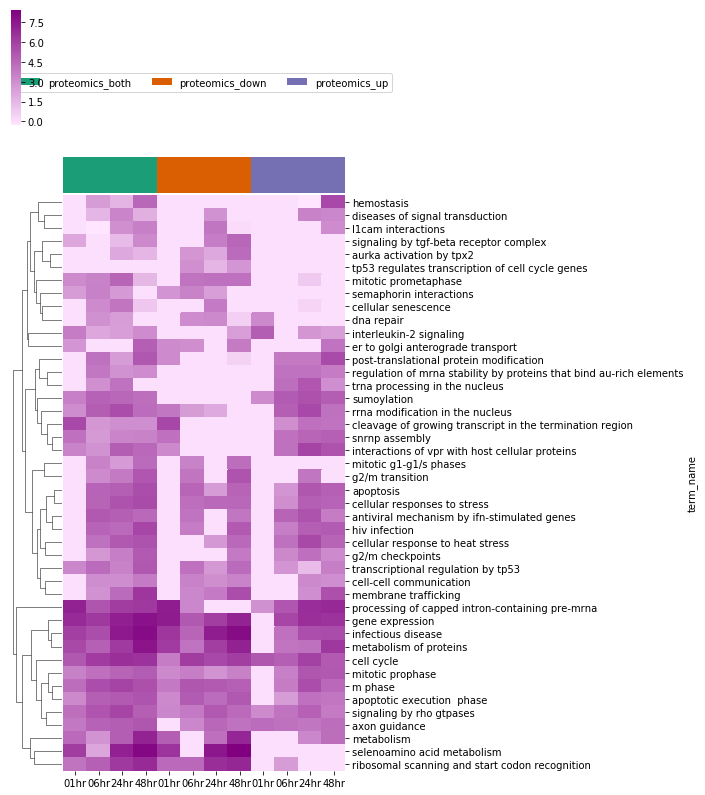

In [19]:
heatmap_by_category(all_data=all_data);

In [ ]:
array = all_data.pivoter(True, columns=['category', 'sample_id'], index='term_name',
                         fill_value=0.0, values='combined_score')

print(array.columns)
color_labels= array.columns.levels[0]
col_labels = list(array.columns.levels[1])
colors = sns.color_palette("Dark2", len(color_labels))
row_colors = [colors[i] for i in array.columns.labels[0]]
array.columns = [col_labels[i] for i in array.columns.labels[1]]

fig = sns.clustermap(array, cmap=sns.light_palette("purple", as_cmap=True),
                     yticklabels='auto', col_colors=row_colors,
                     col_cluster=False, row_cluster=True,
                     figsize=(6,14))

for color, label in zip(colors, color_labels):
    fig.ax_col_dendrogram.bar(0, 0, color=color, label=label, linewidth=0)
fig.ax_col_dendrogram.legend(loc="center", ncol=6);

In [ ]:
display(enrichment_array.head(5))

In [ ]:
# clean up printing by selecting fewer columns
cols = ['term_name', 'rank', 'combined_score', 'n_genes', 'genes', 'sample_id']

In [ ]:
display(enrichment_array[cols].head(5))

## Data stats

In [ ]:
# column types
print(enrichment_array.dtypes)

In [ ]:
# databases 
print(sorted(enrichment_array['db'].unique()))

In [ ]:
# filter only sig terms
sig = enrichment_array[enrichment_array['significant_flag']].copy()

## Filtering and searching the dataframe

In [ ]:
# Filter by terms
d = sig.filter_based_on_words(['death'])
display(d.sort_values('combined_score', ascending=False).head(5))

In [ ]:
drug_dbs = ['DrugMatrix', 'Drug_Perturbations_from_GEO_2014']
drug = enrichment_array.filter_multi(
    p_value=0.05,
    combined_score=0.0, 
    db=drug_dbs,
    rank=100,
    #category='rna_up',
)

In [ ]:
word_cloud = create_wordcloud(drug)
word_cloud.plot('wc_drug_dbs_example.png');

In [ ]:
word_cloud.data.head(10)

# Single database exploration

Here we will focus on the Reactome enrichment.

In [ ]:
reactome_only = enrichment_array.filter_multi(
    p_value=0.05, # only sig pvalues
    combined_score=0.0, # score threshold of positive values 
    db='Reactome_2016', # Only reactome db
    category='proteomics_up', # from this category
    rank=100, # select top 100 from each time point
)

In [ ]:
# This cleans up the term name
display(reactome_only['term_name'].head(5))
reactome_only['term_name'] = reactome_only['term_name'].str.split('_').str.get(0)
display(reactome_only['term_name'].head(5))

In [ ]:
d = reactome_only.filter_based_on_words(['apop'])
display(d.sort_values('combined_score', ascending=False).head(15)[cols])

It is interesting that at the first time point, *apoptotic cleavage of cellular proteins* is up-regulated. Further inspecting this, we find proteins such as ACIN1

In [ ]:
# we can use a word cloud to view what terms are enriched
word_cloud = create_wordcloud(reactome_only)
word_cloud.plot('wc_example.png');

In [ ]:
display(reactome_only[cols].head(15))

In [ ]:
# let's look at the sizes of genes per term
plt.hist(reactome_only['n_genes'], bins=20)
display(reactome_only.describe())

In [ ]:
display(reactome_only.sort_values('n_genes', ascending=False)[cols].head(30))
display(reactome_only.sort_values('n_genes', ascending=False)[cols].head(30)['term_name'].values)

In [ ]:
# Manually select terms with large number of genes that are not useful.
# This is based on person intuition. "Gene expression" and "metabolism" might be useful for some, but 
# here I will elimate as they are not descriptive enough to explain what the drug is doing.

not_useful = ['metabolism', 'gene expression',
              'metabolism of proteins', 'disease',
              'infectious disease', 'immune system',
              'metabolism of amino acids and derivatives',
              'major pathway of rrna processing in the nucleolus',
              'influenza life cycle',
              'processing of capped intron-containing pre-mrna',
              'mrna splicing - major pathway',
              'mrna splicing - minor pathway',
              'innate immune system', 'cell-cell communication',
              'diseases of signal transduction', 'mrna splicing'
             ]

In [ ]:
reactome_only = reactome_only.loc[~reactome_only['term_name'].isin(not_useful)]

display(reactome_only.sort_values('n_genes', ascending=False)[cols].head(15))

In [ ]:
# Now lets look at the first time point. 

test_df = reactome_only.filter_multi(sample_id='01hr')
display(test_df.head(10)[cols])
display(test_df.head(10)[cols].term_name.values)

There are 76 enriched terms. If we look at the top ranked terms, we see that some fo them have similar descriptions "Interlekin...". If we look at the gene list, we can also see that some of the genes are similar. To see if there are redundant terms that are enriched, we can calculate their similarity with the Jaccard Index (intersection over union).
![width=50](https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7)
<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png" alt="Drawing" style="width: 300px;"/>

In [ ]:
test_df.dist_matrix(fig_size=(12,12));

In [ ]:
# Valculate the Jaccard Index and returns a ranked dataframe of terms and scores.
# Higher scores means more similar terms
d = test_df.find_similar_terms('cell cycle')
display(d.head(10))

In [ ]:
d = test_df.find_similar_terms('interleukin-2 signaling')
display(d.head(10))

In [ ]:
d = test_df.find_similar_terms('mapk family signaling cascades')
display(d.head(10))

We can do this for all terms and view the results in a distance matrix.

The dark red represents terms that are highly similar. We can filter all highly similar terms from the matrix.

In [ ]:
test_df.remove_redundant(threshold=.7, level='sample', inplace=True)
test_df.dist_matrix();

In [ ]:
test_df[cols].head(25)

In [ ]:
heatmap_from_array(test_df, convert_to_log=True, fig_size=(4, 6), linewidths=.05);

In [ ]:
term_net, mol_net = nt.create_subnetwork( 
    test_df, 
    network, 
    test_df['term_name'], 
    'first_time_point', 
    create_only=False,
    use_threshold=True
)

In [ ]:
hits = [
        'dna repair', 
        'apoptosis',
        'transcriptional regulation by tp53', 
        'g2/m checkpoints',
        'm phase'
        ]

subset = reactome_only.loc[reactome_only['term_name'].isin(hits)].copy()
heatmap_from_array(subset, 
                   convert_to_log=True, 
                   fig_size=(6, 8), 
                   cluster_row=False, 
                   annotate_sig=True);

In [ ]:

explore = [ 'dna repair', 'apoptosis', 'g2/m checkpoints']
subset = reactome_only.loc[reactome_only['term_name'].isin(explore)].copy()
term_net, mol_net = nt.create_subnetwork( 
    subset, 
    network,  
    save_name='selected_from_first_tp', 
    create_only=False,
    use_threshold=True
)

## Across all time points

In [ ]:
reactome_all_time = reactome_only.remove_redundant(threshold=.6, level='sample')
reactome_all_time.dist_matrix();

In [ ]:
display(reactome_all_time[cols].head(20))

In [ ]:
reactome_all_time.find_similar_terms('formation of incision complex in gg-ner').head(10)

In [ ]:
reactome_all_time[reactome_all_time['term_name'] == 'apoptosis']

In [ ]:
reactome_all_time.filter_by_minimum_sig_columns(
    index='term_name', columns='sample_id', min_terms=2,
    inplace=True
)
reactome_all_time.remove_redundant(threshold=.5, level='dataframe', inplace=True)
reactome_all_time.dist_matrix();

In [ ]:
reactome_all_time.sort_values(by=['combined_score',],
                              inplace=True, 
                              ascending=False)
display(reactome_all_time[cols].head(30))

In [ ]:
heatmap_from_array(reactome_all_time, 
                   convert_to_log=True, 
                   fig_size=(5, 9), 
                   cluster_row=False, 
                   annotate_sig=True);

## Exploring all terms


In [ ]:
term_net, mol_net = nt.create_subnetwork( 
    reactome_all_time, network,
    terms=reactome_all_time['term_name'],  
    save_name='all_example',
    create_only=False,
    use_threshold=True
)

In [ ]:
explore = ['signalling by ngf', 'axon guidance']
subset = reactome_only.loc[reactome_only['term_name'].isin(explore)].copy()
# subset.dist_matrix();
# display(subset)
term_net, mol_net = nt.create_subnetwork( 
    subset, network,
    terms=subset['term_name'],  
    save_name='ngf_axon',
    create_only=False,
    use_threshold=True
)


mol_net = trim_sink_source_nodes(network=mol_net, list_of_nodes=[])
mol_net = delete_disconnected_network(mol_net)

In [ ]:
from magine.enrichment.enrichr import Enrichr
e = Enrichr()

In [ ]:
print("Total genes related = {}".format(len(subset.all_genes_from_df())))
df = e.run(subset.all_genes_from_df(), 
           gene_set_lib=['OMIM_Disease', 'OMIM_Expanded','Jensen_DISEASES','Human_Phenotype_Ontology']
          )
df['sample_id'] = 'NGF_AXON'

In [ ]:
df2 = df.copy()
df2.filter_multi(rank=100, inplace=True, p_value=0.05)
df2.sort_values('combined_score', ascending=False, inplace=True)

df2.head(20)

In [ ]:
view.display_graph(term_net, add_parent=True)

In [ ]:
view.display_graph(mol_net, add_parent=True)


In [ ]:
paint_network_overtime(mol_net, exp_data=exp_data, cluster=True, save_name='apoptosis_ngf', color_list='red')

In [ ]:
apoptosis = subset.term_to_genes('apoptosis')
g2m = subset.term_to_genes('g2/m checkpoints')
ngf = subset.term_to_genes('signalling by ngf')
print(len(ngf))

In [ ]:
subset = exp_data.species[exp_data.species.identifier.isin(ngf)].copy()
print(subset.shape)
subset.filter_by_minimum_sig_columns(index='label',
                                     columns='sample_id', 
                                     min_terms=2, 
                                     inplace=True)
print(subset.shape)

In [ ]:
heatmap_from_array(subset, True, cluster_row=True, 
                   div_colors=True, index='label', values='fold_change',
                   fig_size=(6,16), linewidths=0.01, num_colors=21,
                   annotate_sig=True);

In [ ]:
ngf_net = net_sub.expand_neighbors(None, ngf, 
                                   upstream=True,
                                   downstream=True, 
                                   include_only=ngf)

In [ ]:
ngf_net = trim_sink_source_nodes(ngf_net)
ngf_net = delete_disconnected_network(ngf_net)
print(len(ngf_net.nodes))
print(len(ngf_net.edges))
nx.write_gml(ngf_net, 'ngf_net.gml')

In [ ]:
view.display_graph(ngf_net, add_parent=False)

In [ ]:
exp_data.genes.plot_species(['GSK3B'], 'NGF', plot_type='matplotlib');

In [ ]:
exp_data.genes.plot_species(['CUL3'], 'CUL3', plot_type='matplotlib');

In [ ]:
auditoray = net_sub.neighbors('GSK3B', upstream=True, downstream=False, include_only=exp_data.species.sig.id_list)
print(len(auditoray.nodes))
print(len(auditoray.edges))

In [ ]:
for i,j,d in auditoray.edges(data=True):
    print(d['interactionType'])
    if 'inhibit' not in d['interactionType'] or 'phos' not in d['interactionType']:
        auditoray.remove_edge(i,j)
auditoray = delete_disconnected_network(auditoray)

In [ ]:
view.display_graph(auditoray)

In [ ]:
# new_g = sg.paths_between_list(mol_net_trim.nodes, max_length=3)
new_g = sg.paths_between_two_lists(apoptosis, g2m, max_length=3)
print(len(new_g.nodes))
print(len(new_g.edges))

In [ ]:
from magine.networks.utils import compose
new_g = compose(new_g, mol_net_trim)

In [ ]:
new_nodes = set(mol_net_trim.nodes)
for i in mol_net_trim.nodes:
    if i in new_nodes:
        new_g.node[i]['terms'] = mol_net_trim.node[i]['terms']
        new_g.node[i]['termName'] = mol_net_trim.node[i]['termName']

In [ ]:
view.display_graph(term_net)

In [ ]:
view.display_graph(mol_net, add_parent=True)

In [ ]:
from exp_data import exp_data

In [ ]:
from magine.networks.subgraphs import Subgraph
net_sub = Subgraph(network)

In [ ]:
from magine.networks.visualization.igraph_tools import paint_network_overtime

In [ ]:
paint_network_overtime(new_g, exp_data=exp_data, save_name='metabolites', color_list='red')

In [ ]:
print(reactome_only.shape)

at_least_2 = reactome_only.filter_by_minimum_sig_columns(
    columns='sample_id',
    min_terms=3
)

at_least_2.remove_redundant(inplace=True, level='dataframe')

at_least_2.dist_matrix(fig_size=(8, 8), level='dataframe')


heatmap_from_array(
    at_least_2,
    cluster_row=True, 
    annotate_sig=True, 
    fig_size=(8, 14)
);

In [ ]:
fig = heatmap_from_array(reactome_only,
                         convert_to_log=True,
                         fig_size=(8, 8))

fig.savefig('enrichment.png', dpi=300, bbox_inches='tight')

In [ ]:

fig = heatmap_from_array(reactome_only, 
                         convert_to_log=True, 
                         cluster_col=False, 
                         cluster_row=True, 
                         fig_size=(8, 8))

fig.savefig('cluster_enrichment.png', dpi=300, bbox_inches='tight')

In [ ]:
drug_df = enrichment_array.filter_multi(
    p_value=0.05,
    combined_score=0.0,
    rank=25,
    db=['DrugMatrix', 'Drug_Perturbations_from_GEO_2014']
)
create_wordcloud(drug_df).plot(save_name='word_cloud_rna_drug_dbs');

In [ ]:
sig_array = enrichment_array.filter_multi(
    p_value=0.05, 
    combined_score=0.0, 
    db='GO_Biological_Process_2017b',
    category='proteomics_up'
)


sig_array.remove_redundant(threshold=0.7,
                           inplace=True,
                           level='dataframe')
sig_array.dist_matrix();
fig = heatmap_from_array(sig_array, 
                         convert_to_log=True, 
                         cluster_col=False, 
                         cluster_row=True, 
                         fig_size=(8, 14), annotate_sig=True)

fig.savefig('go_bp_cluster_enrichment.png', dpi=300, bbox_inches='tight')

In [ ]:
apoptosis_genes = d.term_to_genes('apoptosis')

In [ ]:
exp_data.species.plot_species(apoptosis_genes,
                              'apop_genes',
                              plot_type='matplotlib');

In [ ]:
subset = exp_data.genes.loc[exp_data.genes['identifier'].isin(apop_cleavage)].copy()

subset.filter_by_minimum_sig_columns(columns='sample_id', index='label', inplace=True, min_terms=2)

heatmap_from_array(subset, True, values='fold_change', index='label', 
                   linewidths=.1, num_colors=11, cluster_row=True,
                   div_colors=True, annotate_sig=True, fig_size=(8,12));